# Working out in a traditional way

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas DataFrame

df1 = pd.read_csv("/train (1).csv")
df2 = pd.read_csv("/test (1).csv") 

df = pd.concat([df1, df2], axis=0)

df = df.dropna()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Convert the text data into a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train a Naive Bayes classifier on the training data
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate the classifier on the test data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8090551181102362


# modelling using awd - lstm

In [1]:
# Installing and importing the necessary libraries 
!pip install fastai2 
# !pip install kaggle --quiet
!pip install -Uqq fastbook

from fastbook import *
from fastai.text.core import *
from fastai.text.all import *

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# path = Path('../input/nlp-getting-started/')
# Path.BASE_PATH = path
# path.ls()

In [3]:
# train = pd.read_csv('/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')


train = pd.read_csv('/train (1).csv')
test = pd.read_csv('/content/test (1).csv')

In [4]:
train.head() 

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
print(f'The training set has {len(train)} records.')
print(f'The test set has {len(test)} records.')

The training set has 7613 records.
The test set has 3263 records.


In [8]:
# Let's take an example text from our training set to show a tokenization example

txt = train['text'].iloc[0]
txt

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [9]:
# Initializing the default tokenizer used in Fastai which is that of Spacy called `WordTokenizer`
spacy = WordTokenizer() 

# Wrapping the Spacy tokenizer with a custom Fastai function to make some custom changes to the tokenizer
tkn = Tokenizer(spacy) 

tkn(txt)

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [10]:
txts = L([i for i in train['text']])
txts

(#7613) ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all','Forest fire near La Ronge Sask. Canada',"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",'13,000 people receive #wildfires evacuation orders in California ','Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ','#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires','#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',"I'm on top of the hill and I can see a fire in the woods...","There's an emergency evacuation happening now in the building across the street","I'm afraid that the tornado is coming to our area..."...]

In [11]:
# Setting up a tokenizer on the entire dataframe 'train'
tok = Tokenizer.from_df(train)
tok.setup(train)

toks = txts.map(tok)
toks[0]

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [12]:
tok.encodes(toks[0])

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [13]:
tok.decode(toks[0])

'xxbos xxmaj our xxmaj deeds are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all'

In [14]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]


from fastcore.dispatch import retain_meta

def new_retain_meta(x, res):
    "Call `res.set_meta(x)`, if it exists"
    if hasattr(res,'set_meta'): res.set_meta(x)
    return res

retain_meta = new_retain_meta


In [15]:
num.encodes(toks[0])

TensorText([   2,    8,  150,    8,    0,   43,   14,    8,  885,   19,   39,   13,  301,    8,  170,    7, 1620,    8,    0,  120,   65])

In [16]:
num.decode(nums[0][:10])

(#10) ['xxbos','xxmaj','our','xxmaj','xxunk','are','the','xxmaj','reason','of']

In [17]:
# dataset for fine-tuning language model which only needs the text data

df_lm = pd.concat([train, test], axis=0)[['text']]
df_lm.head()

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [18]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [19]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

In [20]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos xxmaj saving the xxmaj city in xxmaj old xxmaj town : xxmaj the xxmaj proposed xxmaj demolition of xxunk xxmaj west xxmaj xxunk http : / / t.co / xxunk xxunk for xxunk xxbos xxmaj great xxmaj british xxmaj bake xxmaj off 's back and xxmaj dorret 's chocolate gateau collapsed - xxup jan xxup xxunk http : / / t.co / xxunk http : / / t.co / xxunk xxbos,xxmaj saving the xxmaj city in xxmaj old xxmaj town : xxmaj the xxmaj proposed xxmaj demolition of xxunk xxmaj west xxmaj xxunk http : / / t.co / xxunk xxunk for xxunk xxbos xxmaj great xxmaj british xxmaj bake xxmaj off 's back and xxmaj dorret 's chocolate gateau collapsed - xxup jan xxup xxunk http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxunk
1,/ t.co / 83joo0xk29 xxbos xxunk xxunk \n xxmaj never dies a big xxmaj crime like xxup xxunk xxup massacre as long the revolution is being xxunk . \n▁ # xxunk xxbos http : / / t.co / xxunk xxmaj correction : xxmaj tent xxmaj collapse story # xxunk xxbos xxunk @kurtschlichter xxmaj here 's the thing : they were xxunk xxup up xxup to a xxup million xxup american xxup casualties,t.co / 83joo0xk29 xxbos xxunk xxunk \n xxmaj never dies a big xxmaj crime like xxup xxunk xxup massacre as long the revolution is being xxunk . \n▁ # xxunk xxbos http : / / t.co / xxunk xxmaj correction : xxmaj tent xxmaj collapse story # xxunk xxbos xxunk @kurtschlichter xxmaj here 's the thing : they were xxunk xxup up xxup to a xxup million xxup american xxup casualties .
2,xxmaj columbus - http : / / t.co / xxunk xxbos xxmaj got my first damage today xxunk xxrep 6 k xxbos * is a wreck * * gives ppl lifestyle advice * xxbos xxmaj the forest service now xxunk > 50 % of its budget fighting fires http : / / t.co / xxunk t xxbos xxunk yes i will probably drown her in xxunk throughout our years but by no,columbus - http : / / t.co / xxunk xxbos xxmaj got my first damage today xxunk xxrep 6 k xxbos * is a wreck * * gives ppl lifestyle advice * xxbos xxmaj the forest service now xxunk > 50 % of its budget fighting fires http : / / t.co / xxunk t xxbos xxunk yes i will probably drown her in xxunk throughout our years but by no means


In [21]:
# Saving the dataloader for fast use in the future

# torch.save(dls_lm, path/'disaster_tweets_dls_lm.pkl')

In [22]:
# To load the Dataloaders in the future

# dls_lm = torch.load(path/'disaster_tweets_dls_lm.pkl')

In [23]:
#fine-tuning wikitext LM to disaster tweets dataset

learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [24]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5832, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5832, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5832, bias=True)
    (output_dp): RNNDropout()
  )
)

SuggestedLRs(valley=0.0063095735386013985)

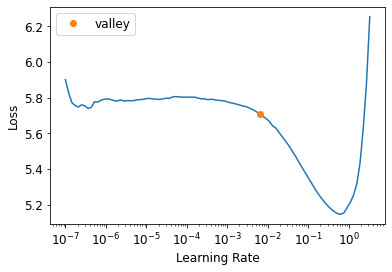

In [25]:
learn.lr_find()

In [26]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.814628,3.772957,0.377754,43.508533,00:14


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.750352,3.445630,0.412366,31.363031,00:15
1,3.479388,3.183777,0.445611,24.137747,00:16
2,3.256997,3.073093,0.459796,21.608629,00:16
3,3.062333,3.026663,0.467392,20.628277,00:15
4,2.949532,3.021790,0.468603,20.527994,00:16


In [27]:
# Saving the encoder

learn.save_encoder('finetuned')

---

In [28]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('target'),
                splitter=RandomSplitter(0.2))

In [29]:
dls = dls.dataloaders(train, bs=64)

In [30]:
dls.show_batch(max_n=3)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
2,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0


In [31]:
len(dls.train_ds), len(dls.valid_ds)

(6091, 1522)

#### Defining the learner

In [32]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1)]).to_fp16()
learn.load_encoder('finetuned')

In [33]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5832, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5832, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


In [34]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.529785,0.457118,0.787122,0.749614,00:10


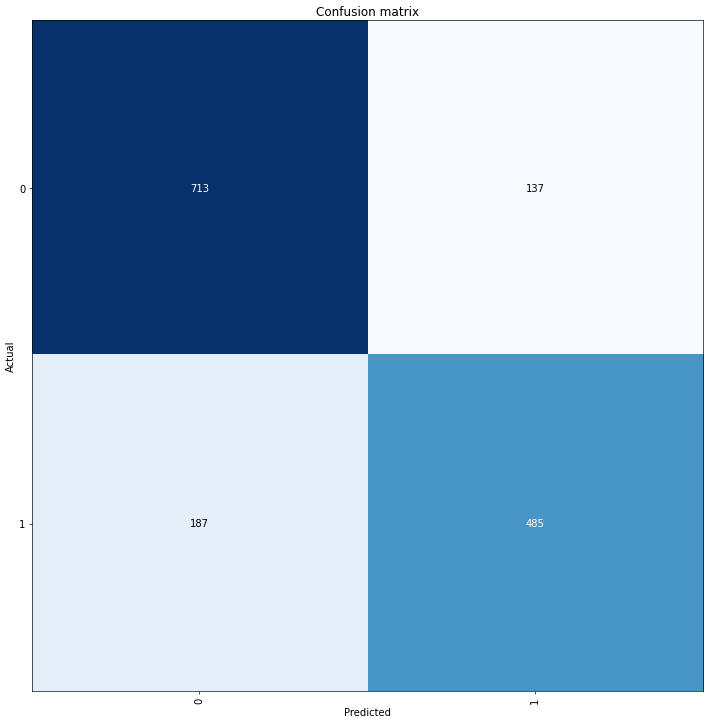

In [35]:
#  What does the confusion matrix look like after a single epoch?
interpretation = ClassificationInterpretation.from_learner( learn )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

In [36]:
# Applying gradual unfreezing of one layer after another

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.520509,0.448029,0.795007,0.765060,00:11


In [37]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.483784,0.441394,0.799606,0.770849,00:13


In [38]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.429514,0.434828,0.801577,0.773952,00:10
1,0.392835,0.438029,0.806176,0.773251,00:11


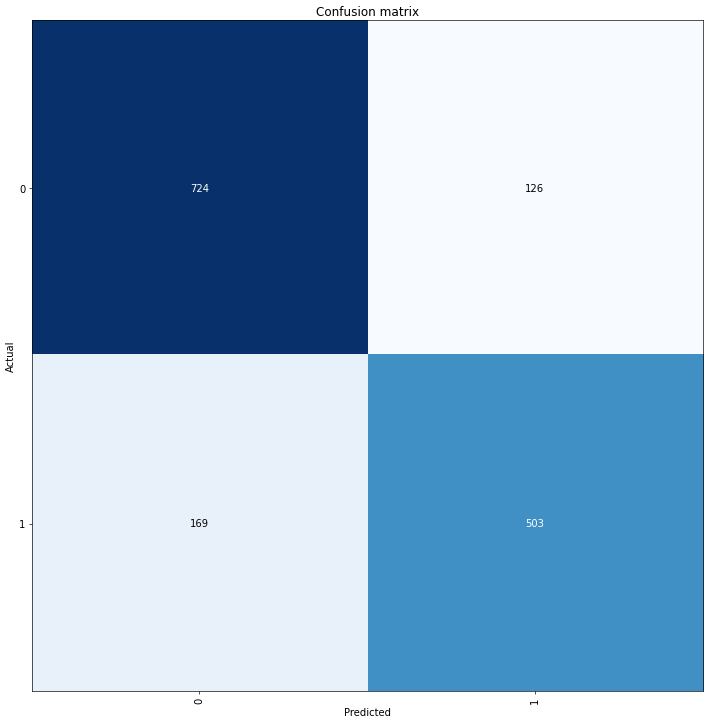

In [39]:
# And finally the confusion matrix
interpretation = ClassificationInterpretation.from_learner( learn )
interpretation.plot_confusion_matrix( figsize = ( 12, 12 ), dpi = 60 )

In [54]:
# Let's end by getting a test accuracy for comparison
pred_scores, targets = learn.get_preds( ) # uses default ds_idx=1 that is validation
preds = torch.argmax( pred_scores, dim=1 )
correct_count = 0
for i in range( len( preds ) ):
  if preds[ i ] == targets[ i ]:
    correct_count = correct_count + 1
accuracy = 100 * ( correct_count / len( preds ) )
print( f'test accuracy: {accuracy}%' )

test accuracy: 80.61760840998686%


In [41]:
learn.save('final_model')

Path('models/final_model.pth')

In [42]:
learn.export()